# Homework #3 Solutions

## Sampling and Monte Carlo Integration

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
from functools import partial
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of the random variable $X$:

$$
h(x) = 7 * \mathrm{exp}\left\{\frac{(x-4)^2}{-2}\right\} + 3 * \mathrm{exp}\left\{\frac{(x-8)^2}{-2 * 0.7^2}\right\}
$$

Our goal is to compute the expected value of $h(X)$:
$$
I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx,
$$
where $\Omega$ is the domain of $f_X$.

## Part I. Implement Some Monte Carlo Estimates

Approximate $\mathbb{E}_{X\sim f_X}[h(X)]$ using the Monte Carlo integration methods and your choice of a reasonable fixed $S$ (for rejection sampling, this means run the algorithm $S$ times):


1. ***Inverse CDF Sampling*** and naive Monte Carlo estimation.<br><br>

2. ***Rejection Sampling*** and naive Monte Carlo estimation, using each of the following

  - a uniform proposal distribution
  - a normal proposal distribution 

  and your choice of reasonable parameters for the proposal distributions.<br><br>
  
3. ***Importance Sampling*** using each of the following

  - a uniform importance distribution 
  - a normal importance distribution

  and your choice of reasonable parameters for the importance distributions.<br><br>
  
2. ***Stratified Sampling*** using 4 strata, whose end points are given by
$$
[1, 3, 5, 7, 9].
$$
Use inverse cdf sampling on each stratum.

**Solution:**
The piecewise definition of the pdf looks intimidating at first glance, so let's visualize it.

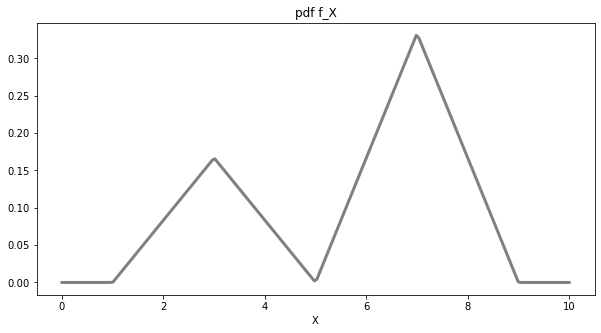

In [2]:
#definition of the pdf
def f_X(x):
    if x >= 1 and x <= 3:
        return 1./12 * (x - 1.)
    elif x > 3 and x <= 5:
        return -1./12 * (x - 5)
    elif x > 5 and x <= 7:
        return 1./6 * (x - 5)
    elif x > 7 and x <= 9:
        return -1./6 * (x - 9)
    else:
        return 0.

#vectorize f_X, so that it takes arrays and inputs!
f_X_vec = np.vectorize(f_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, f_X_vec(x), color='gray', linewidth=3)
ax.set_xlabel('X')
ax.set_title('pdf f_X')
plt.show()

### 1. Inverse Transform Sampling

Recall that the CDF, $F_X$, of our pdf $f_X$ is defined as:
$$
F_X(a)= \int_{-\infty}^a f_X(x)dx, \quad a\in \mathbb{R}
$$
That is, $F_X(a)$ is the area under $f_X$ up to $X=a$. Now, since our pdf is zero when $X < 1$. We rewrite the above as
$$
F_X(a)= \int_{1}^a f_X(x)dx, \quad a\in \mathbb{R}
$$

Since our function is defined piecewise, we can compute the CDF on each piece. We demonstrate this process for the third piece, $5< x\leq 7$:

- the pdf over $[5, 7]$ has the form $\frac{1}{6}(x-5)$; 
- an antiderivative is $\frac{1}{6}\left(\frac{1}{2}x^2-5x\right)$; 
- the CDF over $[5, 7]$ is the area under $f_X$ from $X=1$ to $X=a$, $a\in [5, 7]$;

**Be careful:** you cannot compute the CDF as follows (simply by using the Fundamental Theorem)

$$
F_X(a)= \int_{1}^a f_X(x)dx = \left.\frac{1}{6}\left(\frac{1}{2}x^2-5x\right) \right|_{1}^{a}, \quad a\in [5, 7]
$$

This is because the functional form of the antiderivative is different out side of the interval [5, 7]!

Instead, we break up the pdf as follows:

\begin{aligned}
F_X(a) &= \int_{5}^a f_X(x)dx  + \int_{1}^5 f_X(x)dx \\
&= \left.\frac{1}{6}\left(\frac{1}{2}x^2-5x\right) \right|_{5}^{a} + \frac{1}{3} \\
&= \frac{1}{6}(a^2/2-5a) + \frac{25}{12} + \frac{1}{3}, \quad a\in [5, 7],
\end{aligned}

In the above, we note that the area $\int_{1}^5 f_X(x)dx$ is the area of the small triangle, which is 1/3. 

The shaded region below illustrates the value of $F_X(a)$ for $a\in [5, 7]$.

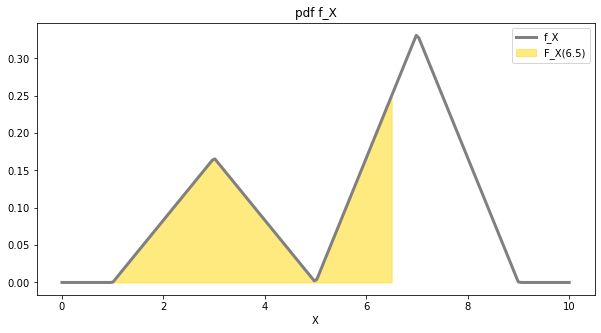

In [3]:
#the upper limit of the integral
a = 6.5

#visualize F_X(a)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

#visualize the pdf f_X
x = np.linspace(0, 10, 200)
ax.plot(x, f_X_vec(x), color='gray', linewidth=3, label='f_X')

#visualize the area under f_X up to x=a
x = np.linspace(1, a, 200)
ax.fill_between(x, f_X_vec(x), color='gold', alpha=0.5, label='F_X({})'.format(a))

ax.set_xlabel('X')
ax.set_title('pdf f_X')
ax.legend(loc='best')
plt.show()

In a similar manner, we compute expressions for the CDF of $X$ on all four pieces of the domain:

$$
F_X(x) = \begin{cases}
0, & x < 1 \\
\frac{1}{12}(x^2/2-x) + \frac{1}{24}, &1\leq x\leq 3\\
-\frac{1}{12}(x^2/2-5x) - \frac{7}{8} + \frac{1}{6}, &3< x\leq 5\\
\frac{1}{6}(x^2/2-5x) + \frac{25}{12} + \frac{1}{3}, &5< x\leq 7\\
-\frac{1}{6}(x^2/2 - 9x) - \frac{77}{12} + \frac{2}{3}, &7< x\leq 9\\
1, &9 < x
\end{cases}
$$

Each piece of $F_X$ can now be inverted, with the help of [WolframAlpha](https://www.wolframalpha.com) if you'd like:

$$
F^{-1}_X(y) = \begin{cases}
1 + 2\sqrt{6y}, &0\leq y\leq \frac{1}{6}\\
5 - 2\sqrt{2(1 - 3y)}, &\frac{1}{6}< y\leq \frac{1}{3}\\
5 + 2\sqrt{3y - 1}, &\frac{1}{3}< y\leq \frac{2}{3}\\
9 - 2\sqrt{3(1 - y)}, &\frac{2}{3}< y\leq 1\\
\end{cases}
$$

We now have all the pieces we need to sample from $f_X$ and we can proceed with inverse CDF sampling to compute
$$
I = \mathbb{E}_{X\sim f_X}\left[ h(X)\right] \approx \sum_{s=1}^{S} h(X_s),\; X_s\sim f_X.
$$

In [4]:
#inverse of the CDF
def F_inv_X(y):
    if y >= 0 and y <= 1./6:
        return 1 + 2 * np.sqrt(6 * y)
    elif y > 1./6 and y <= 1./3:
        return 5 - 2 * np.sqrt(2 * (1 - 3 * y))
    elif y > 1./3 and y <= 2./3:
        return 5 + 2 * np.sqrt(3 * y - 1)
    elif y > 2./3 and y <= 1.:
        return 9 - 2 * np.sqrt(3 * (1 - y))
    else:
        return np.nan

#vectorize the inverse CDF
F_inv_X_vec = np.vectorize(F_inv_X)

#function h
def h(x):
    return 7 * np.exp((x - 4)**2 / -2) + 3 * np.exp((x-8)**2 / (-2 * 0.7**2))

#implementation of inverse transform sampling
def inverse_transform(h, F_inv_X, S):

    #1. sample y-values uniformly from [0, 1]
    y = np.random.uniform(0, 1, S)

    #2. turn these y-values into x-values using the inverse CDF
    x_samples = F_inv_X_vec(y)

    #3. apply h to the x-values and average
    mean_inv = np.mean(h(x_samples))
    
    return x_samples, mean_inv

In [5]:
#number of samples to draw
S = 500 
#get the samples and the MC estimate
inverse_cdf_samples, mean_inv = inverse_transform(h, F_inv_X, S)

print('Inverse Transform estimate of E[h(x)]: {}'.format(mean_inv))

Inverse Transform estimate of E[h(x)]: 2.592445904529598


### 2. Rejection Sampling

Setting up rejection sampling requires us to find a constant $M$ such that $f_X \leq M g$ where $g$ is the proposal distribution. In general, we want $M$ to be as small as possible. However, in this case we will simply pick a $M$ based on visualizations.

In [6]:
#setting up our proposal distributions

#normal pdf: for sampling and evaluation
def normal_dist(mu, sigma, x=None, S=None):
    if x is not None:
        return sp.stats.norm.pdf(x, mu, sigma)
    elif S is not None:
        return np.random.normal(mu, sigma, S)
    else:
        return None

#uniform pdf: for sampling and evaluation
def uniform_dist(a, b, x=None, S=None):
    if x is not None:
        return np.array([1. / (b - a)] * len(x))
    elif S is not None:
        return np.random.uniform(a, b, S)
    else:
        return None

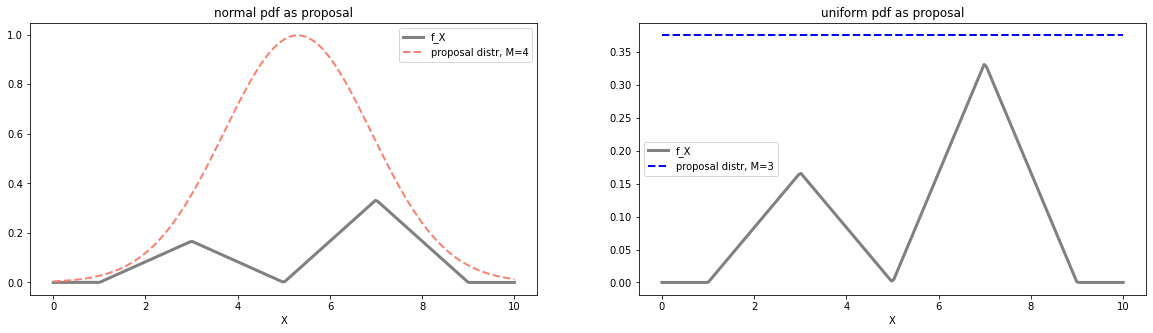

In [7]:
#define a normal proposal distribution 
prop_1 = partial(normal_dist, mu=5.3, sigma=1.6)
#choose an M_1 so that f_X <= M_1 * prop_1
M_1 = 4

#define a uniform proposal distribution
prop_2 = partial(uniform_dist, a=1, b=9)
#choose an M_2 so that f_X <= M_2 * prop_1
M_2 = 3

#visualize M_1 * prop_1, M_2 * prop_1 to make sure they dominate f_X
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
#visualize M_1 * prop_1
ax1.plot(x, f_X_vec(x), color='gray', linewidth=3, label='f_X')
ax1.plot(x, M_1 * prop_1(x=x), '--', color='salmon', linewidth=2, label='proposal distr, M={}'.format(M_1))
ax1.set_xlabel('X')
ax1.set_title('normal pdf as proposal')
ax1.legend(loc='best')
#visualize M_2 * prop_2
ax2.plot(x, f_X_vec(x), color='gray', linewidth=3, label='f_X')
ax2.plot(x, M_2 * prop_2(x=x), '--', color='blue', linewidth=2, label='proposal distr, M={}'.format(M_2))
ax2.set_xlabel('X')
ax2.set_title('uniform pdf as proposal')
ax2.legend(loc='best')
plt.show()

Now that we have our constants and proposal distributions, we can proceed with rejection sampling to compute
$$
I = \mathbb{E}_{X\sim f_X}\left[ h(X)\right] \approx \sum_{s=1}^{S} h(X_s),\; X_s\sim f_X.
$$

In [8]:
##implementation of rejection sampling
def rejection(S, prop_dist, M, true_dist, h):
    #get samples from the proposal distribution
    samples = prop_dist(S=S)
    #get the likelihood ratio of sample under target distribution and proposal distribution
    ratio = true_dist(samples) / (M * prop_dist(x=samples))
    #get uniform random samples between 0 and 1
    U = np.random.uniform(0, 1, size=S)
    #accept samples if U is less than or equal to likelihood ratio
    accepted_sampes = samples[U <= ratio]
    mean_rej = np.mean(h(samples))
    return accepted_sampes, mean_rej, samples

#get the samples and the MC estimate
rej_norm_samples, mean_rej_norm, samples = rejection(S, prop_1, M_1, f_X_vec, h)

print('Rejection Sampling estimate of E[h(x)] (using normal proposal): {}'.format(mean_rej_norm))

Rejection Sampling estimate of E[h(x)] (using normal proposal): 3.375346091159854


In [9]:
rej_uni_samples, mean_rej_uni,samples  = rejection(S, prop_2, M_2, f_X_vec, h)

print('Rejection Sampling estimate of E[h(x)] (using uniform): {}'.format(mean_rej_uni))

Rejection Sampling estimate of E[h(x)] (using uniform): 2.7964523688599034


### 3. Importance Sampling

Recall that the importance sampling estimator of $I$ is defined as
$$
\widehat{I}_{\text{IS}} = \sum_{s=1}^S \frac{f_X(x_s)}{q(x_s)} h(x_s),\; x_s \sim q(X)
$$
where $w_s = \frac{f_X(x_s)}{q(x_s)}$ is the ***importance weight*** of the $s$-th sample.

In [10]:
#implement importance sampling
def importance(S, prop_dist, nom_distribution, h):
    #sample from the proposal distribution
    samples = prop_dist(S=S)
    #compute the weights for the samples
    weights = np.multiply(nom_distribution(samples), prop_dist(x=samples)**-1.)
    #multiply weights to h(x_s) and average over samples
    mean_imp = np.mean(np.multiply(h(samples), weights))
    return weights, mean_imp

weights_imp_norm, mean_imp_norm = importance(S, prop_1, f_X_vec, h)
print('Importance Sampling estimate of E[h(x)] (using normal): {}'.format(mean_imp_norm))

weights_imp_uni, mean_imp_uni = importance(S, prop_2, f_X_vec, h)
print('Importance Sampling estimate of E[h(x)] (using uniform): {}'.format(mean_imp_uni))

Importance Sampling estimate of E[h(x)] (using normal): 2.4690542240772033
Importance Sampling estimate of E[h(x)] (using uniform): 2.4134471936877904


$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

### 4. Stratified Sampling

Since the graph of $f_X$ is a set of two triangular peaks. The area under the smaller triangle is $\frac{1}{3}$ and the area under the larger is $\frac{2}{3}$ (this is just algebra - no calculus required).

Therefore the following integrals can be evaluated geometrically
\begin{align}
\int_{[1, 3]} f_X(x) dx &= \int_{[3, 5]} f_X(x) dx = \frac{1}{6}\\
\int_{[5, 7]} f_X(x) dx &= \int_{[7, 9]} f_X(x) dx = \frac{1}{3}
\end{align}


Thus, we can decompose the integral $I$ as:

$$
I = \mathbb{E}[h(X)] = \frac{1}{6} \left(\int_1^3 h(x) f_{1}(x) dx + \int_3^5 h(x) f_{2}(x) dx \right)+ \frac{1}{3} \left(\int_5^7 h(x) f_{3}(x) dx + \int_7^9 h(x) f_{4}(x) dx\left),
$$

where $f_i$ is $f_X$ renormalized to be a pdf on the $i$-th strata:

$$
f_1 = \frac{6}{12}(x-1),\; f_2 = -\frac{6}{12}(x-5),\; f_3 = \frac{1}{2}(x-5)\; 
f_4 = -\frac{1}{2}(x-9)\;
$$

We will approximate each integral in the above decomposition separately using inverse CDF sampling. From each strata, we will draw a number of points for each stratum that is proportional to the probability of a sampling landing in that stratum. In this case this it means choosing $S_i = 1./6 * S$ or $S_i = 1./3 * S$.

Note that we already have the inverse CDF's for $f_1, f_2$, and we can compute the inverse CDF's for $f_3, f_4$ (for this you can use [Wolfram Alpha](https://www.wolframalpha.com)!):

$$
F^{-1}_1 = 6(1 + 2\sqrt{6y}),\; F^{-1}_2 = 6(5 - 2\sqrt{2(1 - 3y)}),\; F^{-1}_3 = 5 + \sqrt{y},\; F^{-1}_4= 
\begin{cases}
5 + \sqrt{7y + 1}, &y\leq \frac{3}{7}\\
9 - \sqrt{7(1-y)}, &y > \frac{3}{7}\\
\end{cases}
$$

Now we are set to reuse our implementation of inverse CDF sampling and MC estimation to perform stratified sampling.

In [11]:
#define the four inverse pdf's 
F_inv_1 = lambda y: (1 + 2 * np.sqrt(6 * y)) * 6
F_inv_2 = lambda y: (5 - 2 * np.sqrt(2 * (1 - 3 * y))) * 6
F_inv_3 = lambda y: 5 + np.sqrt(y)
F_inv_4 = lambda y: np.where(y < 3. / 7, 5 + np.sqrt(7 * y + 1), 9 - np.sqrt(7 * (1 - y))) 

#implement stratified sampling
def stratified_sampling(h, S):
    

    #list of inverse CDF's
    F = [F_inv_1, F_inv_2, F_inv_3, F_inv_4]
    #list of weights for each stratum
    weights = [1./6, 1./6, 1./3, 1./3]
    
    mean = 0
    samples = []
    
    #estimate on each stratum then sum
    for F_inv_i, w in zip(F, weights):
        #get the right number of points for each stratum
        S_stratum = int(w * S)
        #get samples from the stratum and compute the MC estimate
        samples_i, mean_i = inverse_transform(h, F_inv_i, S_stratum)
        #add the estimates across strata in a weighted way
        mean += w * mean_i
        samples += list(samples_i)

    return np.array(samples), mean

weights_strat, mean_strat = stratified_sampling(h, S)
print('Stratified estimate of E[h(x)]: {}'.format(mean_strat))

Stratified estimate of E[h(x)]: 2.436753142014495


## Part II. Debug Your Samplers

1. Visualize the pdf $f_X$ as well as samples obtained from Inverse CDF Sampling and Rejection Sampling (for both proposal distributions). It's probably better to make separate plots for each set of samples.

  What does the comparison say about the quality of your samples? In particular, which sampler (and which proposal distribution) produces "better" samples? Is this surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?
  
  **Hint:** you might find it helpful to visualize the proposal distributions along with $f_X$ in your analysis of rejection sampling.<br><br>

2. Visualize the distribution of the importance weights (one for each importance distribution). 
  
   Is the weight distribution surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

   What do these importance weights tell you about the quality of your importance sampling estimate? 
   
     **Hint:** you might find it helpful to visualize the importnce distributions along with $f_X$ and $h$ in your analysis of rejection sampling.<br><br>
     
3. Visualize the distribution of all the samples across strata. Is the distribution what you expect -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?<br><br>

4. (**Extra Credit**) Compute the ***effective sample size (ESS)*** of the importance sampling estimates (for both distributions). You'll need to look up the definition of ESS (there are three commonly used definitions, pick any one). How does the effective sample size relate to the trends in the importance weight distributions?

**Solution:**

### 1. Inverse CDF and Rejection Sampling
Let's firt visualize the samples from the inverse CDF sampler.

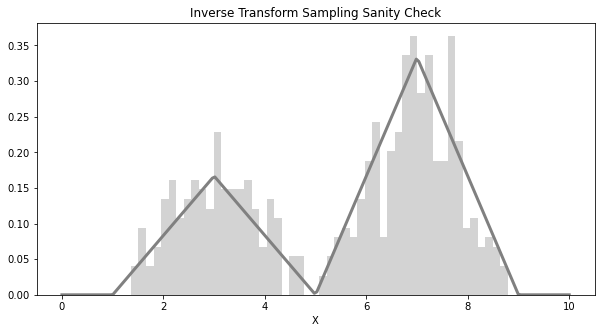

In [12]:
#Sanity check: make sure samples from inverse CDF look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, f_X_vec(x), color='gray', linewidth=3)
ax.hist(inverse_cdf_samples, bins=50, density=True, color='lightgray', linewidth=0)
ax.set_xlabel('X')
ax.set_title('Inverse Transform Sampling Sanity Check')
plt.show()

It looks like that the histogram of the 100 samples align well with the pdf $f_X$. It looks like that the big hump of the pdf is well approximated by our samples, where as the small hump is less so. This indicates that we might wish to increase the sample size $S$ to get a more representative sampling. Recall that it's important for our samples to cover the support of the pdf, since if our samples have "gaps" in their coverages, those $x$ values are never accounted for in our MC estimate leading potentially both to higher variance and higher errors!

Next, we plot the samples from rejection sampling.

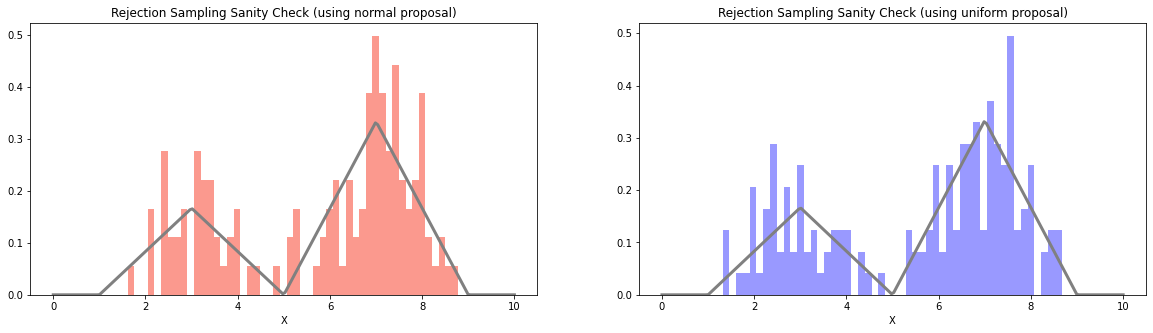

In [13]:
#Sanity check: make sure samples from rejection sampling look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
ax[0].plot(x, f_X_vec(x), color='gray', linewidth=3)
ax[0].hist(rej_norm_samples, bins=50, density=True, color='salmon', alpha=0.8, linewidth=0)
ax[0].set_xlabel('X')
ax[0].set_title('Rejection Sampling Sanity Check (using normal proposal)')

ax[1].plot(x, f_X_vec(x), color='gray', linewidth=3)
ax[1].hist(rej_uni_samples, bins=50, density=True, color='blue', linewidth=0, alpha=0.4)
ax[1].set_xlabel('X')
ax[1].set_title('Rejection Sampling Sanity Check (using uniform proposal)')
plt.show()

It looks like that the samples from the uniform proposal distribution approximates $f_X$ much better than those from the normal proposal distribution! Intuitively, this makes sense, since the normal distribution is more "unlike" the target distribution $f_X$ -- the normal distribution puts most of its mass on values of $x$ that are the least likely under $f_X$.

More formally, recall that the effficiency of the rejection sampler depends on the constant $M$ that bounds the ratio $g/f_X$ -- in particular, the sampler will typically accept $1/M$ of the total number of samples. 

Since $M=4$ for the normal proposal distribution and $M=3$ for the uniform proposal distribution, we'd accept the first sampler to accept $500/4 = 125$ samples and the second to accept $500/3 \approx 166$ samples. Let's check that the number of accepted samples in our simulation matches what we expect.

In [14]:
print('number of samples accepted using normal proposal:', len(rej_norm_samples))
print('number of samples accepted using uniform proposal:', len(rej_uni_samples))

number of samples accepted using normal proposal: 126
number of samples accepted using uniform proposal: 165


Indeed, we find that the sampler using the normal proposal distribution accepts less samples. From intuition and the formal proof from lecture, we know that fewer samples lead to more variance in our MC estimation and any given estimation can have a larger error. 

This indicates that we might prefer to use the MC estimate coming from the uniform proposal distribution

In fact, since the inverse CDF is able to produce more samples from $f_X$ (no sample is rejected), the estimate from inverse CDF sampling should have the least variance and smaller error for any given error, compared with the estimates produced by both rejection samplers.

### 2. Importance Sampling MC Estimate

To sanity check the importance sampling MC estimate, we first visualize the importance weights.

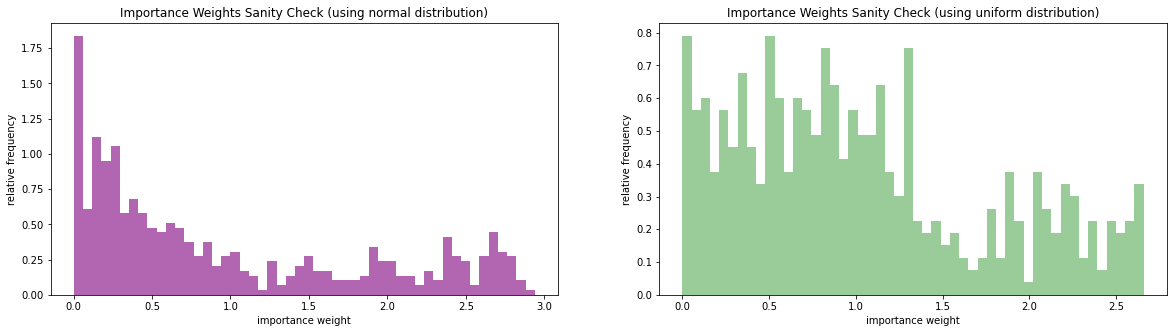

In [15]:
#Sanity check: make sure importance weights from importance sampling with look relatively homogeneous
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
ax[0].hist(weights_imp_norm, bins=50, density=True, color='purple', alpha=0.6, linewidth=0)
ax[0].set_ylabel('relative frequency')
ax[0].set_xlabel('importance weight')
ax[0].set_title('Importance Weights Sanity Check (using normal distribution)')

ax[1].hist(weights_imp_uni, bins=50, density=True, color='green', linewidth=0, alpha=0.4)
ax[1].set_ylabel('relative frequency')
ax[1].set_xlabel('importance weight')
ax[1].set_title('Importance Weights Sanity Check (using uniform distribution)')
plt.show()

It looks like the weights for the normal importance distribution is more heterogeneous than those for the uniform importance distribution. In fact, a significant portion of the weights for the normal importance distribution are close to zero! This makes sense since the normal pdf is non-zero everywhere, so we are often proposing $x$ values smaller than 1 or larger than 9 -- these values will have zero likelihood under $f_X$. Also most of the mass of the normal importance distribution is around values of $x$ that are highly unlikely under $f_X$, this mean, again that we will frequently be sampling $x$ values whose importance weight will be small (since $f_X$ will be small).

In comparison, the weights for the uniform importance distribution are mostly close to 1 or moderately larger than 1. So in some sense, most of the samples we obtain will "count" towards our estimate and count roughly equally. This again is reasonable since the uniform distribution is less dissimlar to $f_X$ and hence it will tend less to propose points that are extremely unlikely under $f_X$.

We can also visualize the comparison of the importance distributions and the product $f_X*h$. Recall that we can hope for a variance reduction when the importance distribution is proportional to $f_X*h$.

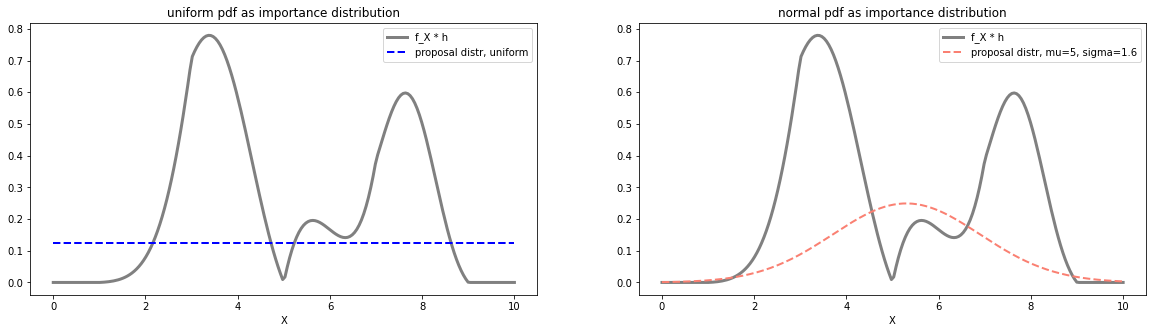

In [16]:
#visualize the importance distributions along with f_X*h
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
ax[0].plot(x, f_X_vec(x) * h(x), color='gray', linewidth=3, label='f_X * h')
ax[0].plot(x, prop_2(x=x), '--', color='blue', linewidth=2, label='proposal distr, uniform')
ax[0].set_xlabel('X')
ax[0].set_title('uniform pdf as importance distribution')
ax[0].legend(loc='best')

ax[1].plot(x, f_X_vec(x) * h(x), color='gray', linewidth=3, label='f_X * h')
ax[1].plot(x, prop_1(x=x), '--', color='salmon', linewidth=2, label='proposal distr, mu={}, sigma={}'.format(5, 1.6))
ax[1].set_xlabel('X')
ax[1].set_title('normal pdf as importance distribution')
ax[1].legend(loc='best')
plt.show()

From the above visualization, we see that neither importance distribution is proportional to $f_X*h$, it's hard to determin by just visual examination which is "worse".

However, since the importance weights of the normal importance distribution is visibly more heterogenous than those of the uniform importance distribution. We may still expect that the variance of MC estimate using the uniform importand distribution will be smaller.

### Stratified Sampling

We visualize the samples from across the strata to check that they are coming from the correct distribution.

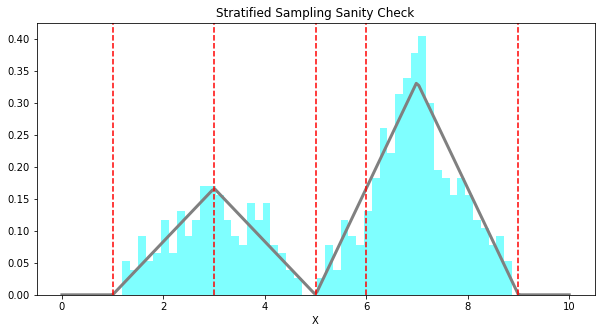

In [20]:
#Sanity check: make sure samples from stratified sampling look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, f_X_vec(x), color='gray', linewidth=3)
ax.hist(weights_strat, bins=50, density=True, color='cyan', alpha=0.5, linewidth=0)
ax.axvline(x=1, linestyle='--', color='red')
ax.axvline(x=3, linestyle='--', color='red')
ax.axvline(x=5, linestyle='--', color='red')
ax.axvline(x=6, linestyle='--', color='red')
ax.axvline(x=9, linestyle='--', color='red')
ax.set_xlabel('X')
ax.set_title('Stratified Sampling Sanity Check')
plt.show()

Recall that stratified sampling works well when the function is relatively "flat" over each strata, we can visualize $h$ over the strata and check if this is the case!

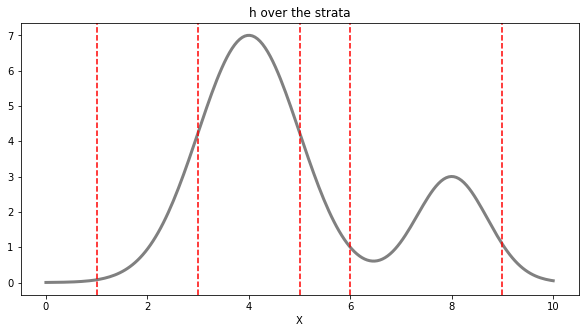

In [19]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, h(x), color='gray', linewidth=3)

ax.axvline(x=1, linestyle='--', color='red')
ax.axvline(x=3, linestyle='--', color='red')
ax.axvline(x=5, linestyle='--', color='red')
ax.axvline(x=6, linestyle='--', color='red')
ax.axvline(x=9, linestyle='--', color='red')
ax.set_xlabel('X')
ax.set_title('h over the strata')
plt.show()

We see that the convinient way in which we carved up the domain of $X$ into strata is not necessarily appropriate for $h$. This means that the variance reduction we get may be very insignificant!

## Part III: Variance Reduction

1. Compute the sample variance of the four MC estimates in Part I. Based on the discussions in lecture, which sampling methods (and proposal/importance distributions) is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?<br><br>

3. Based on your experiments, would you feel comfortable concluding which type of Monte Carlo estimate will **generally** have the lowest variance? Why or why not?<br><br>

4. (**Extra Credit**) Implement the control variate Monte Carlo estimate for $I$ for your choice of a control variate $g$ and sample using the inverse CDF sampler. Argue for why your choice of $g$ is appropriate and demonstrate that your control variate estimate has lower variance than the naive Monte Carlo using inverse CDF sampling.

### 1. Computing sample variance

Variance of these MC estimates can be estimated from sample variance. That is, we repeat the estimation $N$ times, each time using $S$ samples. Then we compute the variance of these estimates across the $N$ trials.

In [21]:
#total number of simulations
n_simulations = 5000

#simulate each estimate repeatedly
var_inv = np.std([inverse_transform(h, F_inv_X, S)[1] for i in range(n_simulations)])
var_imp_1 = np.std([importance(S, prop_1, f_X_vec, h)[1] for i in range(n_simulations)])
var_imp_2 = np.std([importance(S, prop_2, f_X_vec, h)[1] for i in range(n_simulations)])
var_rej_1 = np.std([rejection(S, prop_1, M_1, f_X_vec, h)[1] for i in range(n_simulations)])
var_rej_2 = np.std([rejection(S, prop_2, M_2, f_X_vec, h)[1] for i in range(n_simulations)])
var_strat = np.std([stratified_sampling(h, S)[1] for i in range(n_simulations)])

In [22]:
print('std of inverse cdf: {}'.format(var_inv))
print('std of rejection with normal: {}'.format(var_rej_1))
print('std of rejection with uniform: {}'.format(var_rej_2))
print('std of importance with normal: {}'.format(var_imp_1))
print('std of importance with uniform: {}'.format(var_imp_2))
print('std of stratified sampling: {}'.format(var_strat))

std of inverse cdf: 0.08340988415399925
std of rejection with normal: 0.09858462372826828
std of rejection with uniform: 0.09558418107185422
std of importance with normal: 0.10919741165110498
std of importance with uniform: 0.08628586221277099
std of stratified sampling: 0.08291979179375558


We see that the MC estimate with inverse CDF sampling has lower variance than both estimates using rejection sampling. This is something we already anticipated since we get $S$ samples from $f_X$ using inverse CDF sampling, but we get less that $S$ samples when we use rejection sampling (since many samples will be rejected). The variance for rejection sampling with normal proposal distribution is also higher than that with uniform proposal distribution. This is also anticipated, since the normal proposal distribution yields a smaller number of samples from $f_X$ than the uniform proposal distribution.

The variances of importance sampling MC estimates are both higher that that of MC with inverse CDF sampling. Theoretically speaking, we use importance sampling as a means of variance reduction. However, reduction is attained only with the appropriate choice of importance distribution that yields reasonable importance weights! From the diagnostics we ran in Part II, we already anticipated that the variance of the importance sampling MC estimates will be high since both importance distributions are unideal for $f_X$ and $h$. We expected that the estimate with the normal importance distribution will have a high variance since the corresponding importance weights were very heterogeneous -- this is exactly what we see.

Now, the variance of stratified sampling is smaller but close to the variance of naive MC with inverse CDF sampling. We expect stratified sampling to deliver a variance reduction, which it apparently does, but this reduction may be small (depending on our design choices). We'd anticipated this by visualizing the function $h$ across the strata.

Furthermore, if you ran a smaller number of trials, the sample estimation of the variance itself will be noisy and you may find that the **estimated variance** of stratified sampling can be higher than the **estimated variance** of naive Monte Carlo!

### 2. Overall comparison

From our experiment it's not reasonable to make many definitive generalizations. For example, we can't say that importance sampling is unable to produce variance reduction -- we haven't tried very hard to find an appropriate importance distribution. What this exercise demonstrates is that the design choices we make in these algorithm can have a significant impact on performance and that practically no algorithm works "out-of-the-box". When our choices are ill-considered the actual performance can be orders of magnitude different from the theoretically predicted optimal!